### 身份识别：每个人打相同的标签
### 电影识别：每个电影打相同的标签

In [1]:
import numpy as np
import pyeeg as pe
import matplotlib.pyplot as plt

In [2]:
#加载一个受试者
def loadSub(sub):
    dir='E:\JupyterNotebookWorkSpace\dataSet\\1280x258050(32x8064+2).npy'
    data=np.load(dir)
    subData = data[sub * 40 : (sub + 1) * 40, :-2]
    return subData, np.array([sub for _ in range(40)]).reshape((-1, 1))

In [3]:
# #数据集切60片，基线单独返回
# def data_session(subData):
#     features = subData[:,:-2]
#     labels = subData[:,-2:]
#     features = features.reshape(40,32,-1)
#     features = features[:,:,384:]
    
#     dataList = []
#     for i in range(40):
#         for j in range(60):
#             dataList.append(np.append(features[i][ : , j * 128 : (j + 1) * 128].reshape(-1) , labels[i]))

#     dataList = np.array(dataList)

#     return dataList

In [4]:
#特征提取
def feature_extraction(trainData):

    band = [4,8,13,16,30,45] #5 bands    band = [4,8,12,16,25,45]
    sample_rate = 128 #Sampling rate of 128 Hz

    features = trainData.reshape(trainData.shape[0], 32, 8064)
    features = features[:, :, 384:]

    newData=[]
    for i in range(features.shape[0]):    #样本数
        channel_features=[]
        for j in range(32):
            X = features[i][j]
            Y = pe.bin_power(X, band, sample_rate)
            channel_features += list(Y[0])
        newData.append(np.array(channel_features))
    trainData = np.array(newData)

    return trainData

In [5]:
# AllSubFreq = []    #保存所有受试者的频域特征32*40*162
# for sub in range(32):
#     SubData, label = loadSub(sub)
#     trainData = feature_extraction(SubData)
#     AllSubFreq.append(np.append(trainData, label, axis = 1))
# AllSubFreq = np.array(AllSubFreq)
# print(AllSubFreq.shape) #(32, 40, 161)
# print(AllSubFreq)
# np.save("./rawSignal.npy",AllSubFreq)

In [6]:
def Gaussian_normalization(trainData, testData):
    """高斯归一化"""

    #训练样本归一化
    feature=trainData[:,:-1]
    mean=feature.mean(axis=0)
    std=feature.std(axis=0)
    feature-=mean
    feature/=std
    trainData[:,:-1] = feature

    #测试样本归一化
    feature=testData[:,:-1]
    feature-=mean
    feature/=std
    testData[:,:-1] = feature

    return trainData, testData

In [7]:
from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

def trainModel(trainData, testData):
    
    trainLabel = trainData[:, -1]
    trainData = trainData[:, :-1]
    
    testLabel = testData[:, -1]
    testData = testData[:, :-1]
    
#     svmModel = svm.SVC()
#     svmModel.fit(data_training, valtrain) 
#     ypredict=svmModel.predict(data_testing)
#     print("SVMacc：",accuracy_score(ypredict,valtest)) 

    rfModel = RandomForestClassifier(n_estimators=512, n_jobs=16)
    rfModel.fit(trainData, trainLabel)
    ypredict = rfModel.predict(testData)
    acc = accuracy_score(ypredict,testLabel)
    print("acc = {}".format(acc), end = '\t')
    return acc

In [8]:
allAcc = []

# 数据集划分
AllSubFreq = np.load("./rawSignal.npy")
AllSubFreq = AllSubFreq.reshape((1280, 161))

for SEED in range(100):
    np.random.seed(SEED)
    np.random.shuffle(AllSubFreq)
    ratio = 0.2
    trainSet = AllSubFreq[:int(ratio * AllSubFreq.shape[0])]
    testSet = AllSubFreq[int(ratio * AllSubFreq.shape[0]):]
    
    if SEED == 0:
        print('trainNum.shape = {}, testNum.shape = {}'.format(trainSet.shape, testSet.shape))

    #------------------------------------是否归一化------------------------------------
    normal = True
    if normal:
        trainSet, testSet = Gaussian_normalization(trainSet, testSet)

    # 训练
    print('seed = ', SEED, end = ' : ')
    acc = trainModel(trainSet, testSet)
    allAcc.append(acc)

trainNum.shape = (256, 161), testNum.shape = (1024, 161)
seed =  0 : acc = 0.986328125	seed =  1 : acc = 0.98828125	seed =  2 : acc = 0.98828125	seed =  3 : acc = 0.990234375	seed =  4 : acc = 0.9931640625	seed =  5 : acc = 0.978515625	seed =  6 : acc = 0.99609375	seed =  7 : acc = 0.9931640625	seed =  8 : acc = 0.99609375	seed =  9 : acc = 0.9765625	seed =  10 : acc = 0.984375	seed =  11 : acc = 0.990234375	seed =  12 : acc = 0.990234375	seed =  13 : acc = 0.9912109375	seed =  14 : acc = 0.9912109375	seed =  15 : acc = 0.986328125	seed =  16 : acc = 0.9892578125	seed =  17 : acc = 0.9921875	seed =  18 : acc = 0.99609375	seed =  19 : acc = 0.9931640625	seed =  20 : acc = 0.9892578125	seed =  21 : acc = 0.99609375	seed =  22 : acc = 0.9873046875	seed =  23 : acc = 0.990234375	seed =  24 : acc = 0.9921875	seed =  25 : acc = 0.96875	seed =  26 : acc = 0.9912109375	seed =  27 : acc = 0.990234375	seed =  28 : acc = 0.9912109375	seed =  29 : acc = 0.990234375	seed =  30 : acc = 0.998046875	s

In [9]:
allAcc = np.array(allAcc)

maxIndex = allAcc.argmax()
print('meanAcc = ', allAcc.mean(),'seed = ', maxIndex, 'maxAcc = ',allAcc.max(), 'var = ',allAcc.var())

meanAcc =  0.99060546875 seed =  30 maxAcc =  0.998046875 var =  1.8134689331054683e-05


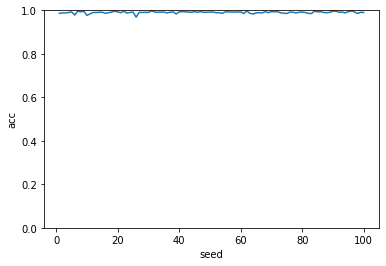

In [10]:
plt.ylim([0,1])
plt.xlabel('seed')
plt.ylabel('acc')
plt.plot(range(1,101), allAcc)